# Отток клиентов

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle

In [2]:
try:
    data = pd.read_csv('сhurn.csv') 
except:
    print('Ошибка загрузки данных')
    
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


**Проверка на пропуски**

In [4]:
data.isna().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

In [5]:
# оценка доли строк с пропусками в столбце "Tenure"

ratio = data['Tenure'].isna().sum() / data.shape[0]
print(f'Доля пропусков в столбце "Tenure": {ratio:.1%}')

Доля пропусков в столбце "Tenure": 9.1%


In [6]:
data = data.dropna(subset=['Tenure']).reset_index(drop=True)
data.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

**Смена названий столбцов**

In [7]:
data.columns = ['Row_Number', 'Customer_Id', 'Surname', 'Credit_Score', 'Geography', 'Gender', 'Age',\
                'Tenure', 'Balance', 'Num_Of_Products', 'Has_Cr_Card', 'Is_Active_Member', 'Estimated_Salary', 'Exited']
data.columns = data.columns.str.lower()
data.columns

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')

Для построения моделей нам не потребуются данные из следующих столбцов: 'row_number', 'customer_id', 'surname' - эти столбцы содержат данные, идентифицирующие пользователя, но не описывающие его поведение, как клиента банка. Разделим данные на два датасета и будем работать только с одним из них.

In [8]:
data_ind = data[['row_number', 'customer_id', 'surname']]
data = data.drop(['row_number', 'customer_id', 'surname'], axis=1) # данные для дальнейшей работы
data

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9086,800,France,Female,29,2.0,0.00,2,0,0,167773.55,0
9087,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9088,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9089,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1


**Вывод**

Проведена предобработка данных: удалены строки с пропусками с столбце "Tenure", произведена смена названий столбцов, отобраны столбцы с необходимыми признаками для дальнейшего анализа.

## Исследование задачи

**Проверка данных на дисбаланс в столбце с целевым признаком**

0    7237
1    1854
Name: exited, dtype: int64

Отношение вероятности класса "0" к количеству класса "1": 3.9


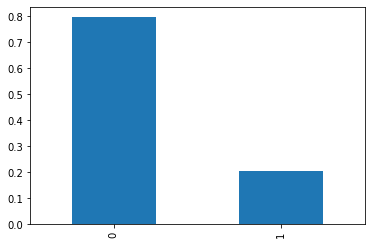

In [9]:
print(data['exited'].value_counts(), end='\n\n')
print(f'Отношение вероятности класса "0" к количеству класса "1": {7963 / 2037:.1f}')

class_frequency = data['exited'].value_counts(normalize=True)
class_frequency.plot(kind='bar');

Данные не сбалансированны, нулей в колонке с целевым признаком почти в четыре раза больше, чем единиц.

**Проверка работы моделей без учёта дисбаланса данных**<br>

Так как стоит задача классификации, в работе будут исследованы модели решающего дерева, случайного леса и логистической регрессии.

In [10]:
# разбиение на признаки и целевой признак

features = data.drop('exited', axis=1)
target = data['exited']


# разделение на обучающую, валидационную и тестовые выборки в отношении 3:1:1 (60%:20%:20%).

#разбиение на обучающую (train) и валидационную+тестовую (validtest) выборки в отношении 60%:40%.

features_train, features_validtest, target_train, target_validtest = train_test_split(
    features, target, test_size=0.4, random_state=12345, stratify=target)

# разбиение на валидационную (valid) и тестовую (test) выборки

features_valid, features_test, target_valid, target_test = train_test_split(
    features_validtest, target_validtest, test_size=0.5, random_state=12345, stratify=target_validtest)

In [11]:
print(f"Количество строк в target_train по классам: {np.bincount(target_train)}")
print(f"Количество строк в target_validtest по классам: {np.bincount(target_validtest)}")

# проверка соотношения
4778 / 1222 - 3185 / 815

Количество строк в target_train по классам: [4342 1112]
Количество строк в target_validtest по классам: [2895  742]


0.002008173265189317

In [12]:
# проверка корректности разбиения по количеству

data.shape[0] - target_train.shape[0] - target_valid.shape[0] - target_test.shape[0]

0

**Преобразование признаков**<br>

В данных помимо количественных признаков присутствуют категориальные: "geography", "gender". 

In [13]:
features_train = pd.get_dummies(features_train, drop_first=True)
features_valid = pd.get_dummies(features_valid, drop_first=True)
features_test = pd.get_dummies(features_test, drop_first=True)

In [14]:
display(features_train.head())
display(features_valid.head())
display(features_test.head())

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
8837,526,32,7.0,125540.05,1,0,0,86786.41,0,0,1
1090,500,47,8.0,128486.11,1,1,0,179227.12,0,1,0
7609,802,40,4.0,0.00,2,1,1,81908.09,0,1,1
7279,731,39,2.0,126816.18,1,1,1,74850.93,0,1,0
2245,612,26,4.0,0.00,2,1,1,179780.74,0,1,0


,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
6800,610,37,10.0,140363.95,2,1,1,129563.86,0,1,0
4950,661,41,5.0,122552.48,2,0,1,120646.40,1,0,1
8287,753,51,4.0,79811.72,2,0,1,68260.27,0,1,1
8912,569,30,3.0,139528.23,1,1,1,33230.37,0,1,0
8265,597,38,6.0,115702.67,2,1,1,25059.05,0,1,1


,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
3726,675,32,10.0,0.00,2,1,0,191545.65,0,1,1
4661,784,38,1.0,138515.02,1,1,1,171768.76,1,0,1
8400,644,49,10.0,0.00,2,1,1,145089.64,0,1,1
6135,717,36,2.0,102989.83,2,0,1,49185.57,0,1,1
8853,677,25,3.0,0.00,2,1,0,179608.96,0,0,0


**Масштабирование признаков**

In [15]:
numeric = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products','has_cr_card', 'is_active_member', 'estimated_salary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

pd.options.mode.chained_assignment = None

**Классификация деревом решений** 

In [16]:
# решающее дерево (1)

best_f1 = 0
best_model_1 = None
best_depth = 0
best_auc_roc = 0

for depth in range(1, 20):
    
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    
    f1 = f1_score(target_valid, predicted_valid)
    
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    
    if f1 > best_f1:
        best_f1 = f1
        best_model_1 = model
        best_depth = depth
        best_auc_roc = auc_roc
        
print(f'F1-мера: {best_f1}, depth: {best_depth}, AUC_ROC: {best_auc_roc}')

# сохранение данных для построения таблиц

table_f1_1 = best_f1
table_ar_1 = best_auc_roc

F1-мера: 0.5815126050420169, depth: 7, AUC_ROC: 0.8245379882534177


**Классификация случайным лесом**

In [17]:
# случайный лес (2)

best_f1 = 0
best_model_2 = None
best_est = 0
best_depth = 0
best_auc_roc = 0

for est in range(100, 300, 5):
    for depth in range(5, 50, 5):
        
        model = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=12345)
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        
        f1 = f1_score(target_valid, predicted_valid)
        
        probabilities_valid = model.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
    
        auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    
        if f1 > best_f1:
            best_f1 = f1
            best_model_2 = model
            best_est = est
            best_depth = depth
            best_auc_roc = auc_roc
        
print(f'F1-мера: {best_f1}, n-estimators: {best_est}, depth: {best_depth}, AUC-ROC: {best_auc_roc}')

table_f1_2 = best_f1
table_ar_2 = best_auc_roc

F1-мера: 0.6098360655737705, n-estimators: 100, depth: 20, AUC-ROC: 0.8690794412456668
CPU times: user 7min 47s, sys: 3.21 s, total: 7min 50s
Wall time: 7min 51s


**Классификация с помощью логистической регрессии**

In [18]:
# логистическая регрессия (3)

model_3 = LogisticRegression(max_iter=1000, solver='liblinear', random_state=12345)
model_3.fit(features_train, target_train)
predicted_valid = model_3.predict(features_valid)

f1 = f1_score(target_valid, predicted_valid)
        
probabilities_valid = model_3.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print(f'F1-мера: {f1}, AUC-ROC: {auc_roc}')


table_f1_3 = f1
table_ar_3 = auc_roc

F1-мера: 0.3306772908366534, AUC-ROC: 0.7892563292023462


**ВЫВОД**

Таким образом, моделью с наибольшей F1-мерой является модель случайного леса (количество деревьев и и максимальная глубина равны 100 и 20 соответственно). Значение F1-меры равно 0.6098360655737705, значение AUC-ROC равно 0.8690794412456668.

## Борьба с дисбалансом

Для учитывания наличия дисбаланса данных в столбце с целевым признаком будут рассмотрены методы взвешивания классов, методы upsampling и downsampling. 

**МЕТОД ВЗВЕШИВАНИЯ КЛАССОВ**

***Классификация деревом решений***

In [19]:
# решающее дерево (4)

best_f1 = 0
best_model_4 = None
best_depth = 0
best_auc_roc = 0

for depth in range(1, 20):
    
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345, class_weight='balanced')
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    
    f1 = f1_score(target_valid, predicted_valid)
    
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    
    if f1 > best_f1:
        best_f1 = f1
        best_model_4 = model
        best_depth = depth
        best_auc_roc = auc_roc
        
print(f'F1-мера: {best_f1}, depth: {best_depth}, AUC-ROC: {best_auc_roc}')


table_f1_4 = best_f1
table_ar_4 = best_auc_roc

F1-мера: 0.583084577114428, depth: 6, AUC-ROC: 0.8353643657199484


***Классификация случайным лесом***

In [20]:
# случайный лес (5)

best_f1 = 0
best_model_5 = None
best_est = 0
best_depth = 0
best_auc_roc = 0

for est in range(100, 300, 5):
    for depth in range(5, 50, 5):
        
        model = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=12345, class_weight='balanced')
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        
        f1 = f1_score(target_valid, predicted_valid)
        
        probabilities_valid = model.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
    
        auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    
        if f1 > best_f1:
            best_f1 = f1
            best_model_5 = model
            best_est = est
            best_depth = depth
            best_auc_roc = auc_roc
        
print(f'F1-мера: {best_f1}, n_estimators: {best_est}, depth: {best_depth}, AUC-ROC: {best_auc_roc}')

table_f1_5 = best_f1
table_ar_5 = best_auc_roc

F1-мера: 0.6497326203208557, n_estimators: 235, depth: 10, AUC-ROC: 0.8743547855308036
CPU times: user 7min 58s, sys: 4.13 s, total: 8min 2s
Wall time: 8min 2s


***Классификация с помощью логистической регрессии***

In [21]:
# логистическая регрессия (6)

model_6 = LogisticRegression(max_iter=1000, solver='liblinear', random_state=12345, class_weight='balanced')
model_6.fit(features_train, target_train)
predicted_valid = model_6.predict(features_valid)

f1 = f1_score(target_valid, predicted_valid)
        
probabilities_valid = model_6.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print(f'F1-мера: {f1}, AUC-ROC: {auc_roc}')

table_f1_6 = f1
table_ar_6 = auc_roc

F1-мера: 0.5065420560747663, AUC-ROC: 0.7907260490614472


**МЕТОД UPSAMPLING**

In [22]:
# получение новых features_upsampled и target_upsampled вместо features_train и target_train 

def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

***Классификация деревом решений***

In [23]:
# решающее дерево (7)

best_f1 = 0
best_model_7 = None
best_depth = 0
best_auc_roc = 0

for depth in range(1, 20):
    
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(features_valid)
    
    f1 = f1_score(target_valid, predicted_valid)
    
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    
    if f1 > best_f1:
        best_f1 = f1
        best_model_7 = model
        best_depth = depth
        best_auc_roc = auc_roc
        
print(f'F1-мера: {best_f1}, depth: {best_depth}, AUC-ROC: {best_auc_roc}')

table_f1_7 = best_f1
table_ar_7 = best_auc_roc

F1-мера: 0.5825049701789264, depth: 6, AUC-ROC: 0.8347040163029001


***Классификация случайным лесом***

In [24]:
# случайный лес (8)

best_f1 = 0
best_model_8 = None
best_est = 0
best_depth = 0
best_auc_roc = 0

for est in range(100, 300, 5):
    for depth in range(5, 50, 5):
        
        model = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=12345)
        model.fit(features_upsampled, target_upsampled)
        predicted_valid = model.predict(features_valid)
        
        f1 = f1_score(target_valid, predicted_valid)
        
        probabilities_valid = model.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
    
        auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    
        if f1 > best_f1:
            best_f1 = f1
            best_model_8 = model
            best_est = est
            best_depth = depth
            best_auc_roc = auc_roc
        
print(f'F1-мера: {best_f1}, n_estimators: {best_est}, depth: {best_depth}, AUC-ROC: {best_auc_roc}')

table_f1_8 = best_f1
table_ar_8 = best_auc_roc

F1-мера: 0.6416184971098267, n_estimators: 275, depth: 20, AUC-ROC: 0.8691315986044181
CPU times: user 10min 34s, sys: 2.95 s, total: 10min 37s
Wall time: 10min 37s


***Классификация с помощью метода логистической регрессии***

In [25]:
# логистическая регрессия (9)

model_9 = LogisticRegression(max_iter=1000, solver='liblinear', random_state=12345)
model_9.fit(features_upsampled, target_upsampled)
predicted_valid = model_9.predict(features_valid)

f1 = f1_score(target_valid, predicted_valid)
        
probabilities_valid = model_9.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print(f'F1-мера: {f1}, AUC-ROC: {auc_roc}')

table_f1_9 = f1
table_ar_9 = auc_roc

F1-мера: 0.5050878815911193, AUC-ROC: 0.7907185980101968


**МЕТОД DOWNSAMPLING**

In [26]:
# получение новых features_downsampled и target_downsampled вместо features_train и target_train

def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

***Классификация деревом решений***

In [27]:
# дерево (10)

best_f1 = 0
best_model_10 = None
best_depth = 0
best_auc_roc = 0

for depth in range(1, 20):
    
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model.fit(features_downsampled, target_downsampled)
    predicted_valid = model.predict(features_valid)
    
    f1 = f1_score(target_valid, predicted_valid)
    
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    
    if f1 > best_f1:
        best_f1 = f1
        best_model_10 = model
        best_depth = depth
        best_auc_roc = auc_roc
        
print(f'F1-мера: {best_f1}, depth: {best_depth}, AUC-ROC: {best_auc_roc}')

table_f1_10 = best_f1
table_ar_10 = best_auc_roc

F1-мера: 0.5688442211055276, depth: 6, AUC-ROC: 0.8456375026311528


***Классификация случайным лесом***

In [28]:
# лес (11)

best_f1 = 0
best_model_11 = None
best_est = 0
best_depth = 0
best_auc_roc = 0

for est in range(100, 300, 5):
    for depth in range(5, 50, 5):
        
        model = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=12345)
        model.fit(features_downsampled, target_downsampled)
        predicted_valid = model.predict(features_valid)
        
        f1 = f1_score(target_valid, predicted_valid)
        
        probabilities_valid = model.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
    
        auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    
        if f1 > best_f1:
            best_f1 = f1
            best_model_11 = model
            best_est = est
            best_depth = depth
            best_auc_roc = auc_roc
        
print(f'F1-мера: {best_f1}, n_estimators: {best_est}, depth: {best_depth}, AUC-ROC: {best_auc_roc}')

table_f1_11 = best_f1
table_ar_11 = best_auc_roc

F1-мера: 0.6169989506820567, n_estimators: 260, depth: 10, AUC-ROC: 0.881582305243491
CPU times: user 4min 33s, sys: 1.82 s, total: 4min 34s
Wall time: 4min 35s


***Классификация с помощью логистической регрессии***

In [29]:
# лог регрессия (12)

model_12 = LogisticRegression(max_iter=1000, solver='liblinear', random_state=12345)
model_12.fit(features_downsampled, target_downsampled)
predicted_valid = model_12.predict(features_valid)

f1 = f1_score(target_valid, predicted_valid)
        
probabilities_valid = model_12.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print(f'F1-мера: {f1}, AUC-ROC: {auc_roc}')

table_f1_12 = f1
table_ar_12 = auc_roc

F1-мера: 0.5073529411764706, AUC-ROC: 0.7911824259505214


**ВЫВОД**

In [30]:
# таблица с F1-мерой

tab1_data = {'Без баланса':[table_f1_1, table_f1_2, table_f1_3], 'Взвешивание классов':[table_f1_4, table_f1_5, table_f1_6],\
             'Upsampling':[table_f1_7, table_f1_8, table_f1_9], 'Downsampling':[table_f1_10, table_f1_11, table_f1_12]} 
tabl_1 = pd.DataFrame(tab1_data, index =['Дерево решений', 'Случайный лес', 'Логистическая регрессия']) 
display(tabl_1)

# таблица с AUC-ROC

tab2_data = {'Без баланса':[table_ar_1, table_ar_2, table_ar_3], 'Взвешивание классов':[table_ar_4, table_ar_5, table_ar_6],\
             'Upsampling':[table_ar_7, table_ar_8, table_ar_9], 'Downsampling':[table_ar_10, table_ar_11, table_ar_12]} 
tabl_2 = pd.DataFrame(tab2_data, index =['Дерево решений', 'Случайный лес', 'Логистическая регрессия']) 
display(tabl_2)

,Без баланса,Взвешивание классов,Upsampling,Downsampling
Дерево решений,0.581513,0.583085,0.582505,0.568844
Случайный лес,0.609836,0.649733,0.641618,0.616999
Логистическая регрессия,0.330677,0.506542,0.505088,0.507353


,Без баланса,Взвешивание классов,Upsampling,Downsampling
Дерево решений,0.824538,0.835364,0.834704,0.845638
Случайный лес,0.869079,0.874355,0.869132,0.881582
Логистическая регрессия,0.789256,0.790726,0.790719,0.791182


Моделью с максимальной F1-мерой является модель случайного леса с применённым методом взвешивания классов с количеством деревьев 235 и максимальной глубиной 10 (best_model_5). Полученные значения F1-меры и AUC-ROC равны 0.6459459459459459 и 0.8751762639311373 соответственно.

In [31]:
best_model_5

RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=235,
                       random_state=12345)

## Тестирование модели

In [32]:
predicted_test = best_model_5.predict(features_test)
        
f1 = f1_score(target_test, predicted_test)
        
probabilities_test = best_model_5.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
    
auc_roc = roc_auc_score(target_test, probabilities_one_test)

print(f'F1-мера: {f1}, AUC-ROC: {auc_roc}')

F1-мера: 0.6075949367088608, AUC-ROC: 0.850342883948117


# Вывод

Моделью с максимальной F1-мерой является модель случайного леса с применённым методом "взвешивание классов" с количеством деревьев 235 и максимальной глубиной 10. <br><br>
Полученные для тестовой выборки значения F1-меры и AUC-ROC равны 0.6067415730337079 и 0.852379339101428 соответственно.